In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import fastai
from fastai.vision import *
from fastai.vision.gan import *

You should set the following option to True if the notebook isn't located in the file system inside a clone of the git repo (with the needed Python modules available) it belongs to; i.e., it's running independently.

In [0]:
run_as_standalone_nb = True

In [0]:
# This cell needs to be executed before importing local project modules, like import genlab.core.gan
if run_as_standalone_nb:
    root_lib_path = os.path.abspath('generative-lab')
    if not os.path.exists(root_lib_path):
        !git clone https://github.com/davidleonfdez/generative-lab.git
    if root_lib_path not in sys.path:
        sys.path.insert(0, root_lib_path)
else:
    import local_lib_import

In [0]:
# Local project modules. Must be imported after local_lib_import or cloning git repo.
from genlab.core.biggan import biggan_disc_64, biggan_gen_64, BigGANGenImagesSampler
from genlab.core.data import BigGANItemList
from genlab.core.gan import GANLossArgs, save_gan_learner, ConditionalGANLearner
from genlab.core.losses import hinge_adversarial_losses, loss_func_with_kernel_regularizer, OrthogonalRegularizer

In [0]:
# Point this variable to the path where you want to save your models
models_root = Path('./')

In [0]:
img_size = 64
img_n_channels = 3
# Std bs is 512-2048
batch_size = 64 
# Std ch is 64-96
ch_mult = 32     
n_classes = 10

In [0]:
# Disable occasional annoying warnings produced by libraries using pytorch, which 
# may collapse the output during data loading or training
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# DATA

Set `real_images_path` to the location of the dataset you want to work with.  If needed, as a previous step, fastai provides the method `untar_data` to download and extract a dataset from a remote URL.

In [8]:
real_images_path = untar_data(URLs.MNIST)
real_images_path

PosixPath('/root/.fastai/data/mnist_png')

In [0]:
def resolve_cat(img_path:Path) -> str:
    cat_name = img_path.resolve().parts[-2]
    return cat_name

def get_data(path, bs, size, n_classes, noise_sz=100):
    return (BigGANItemList.from_folder(path, noise_sz=noise_sz, n_classes=n_classes)
               .split_none()
               .label_from_func(noop, resolve_cat_func=resolve_cat)
               .transform(tfms=[[crop_pad(size=size, row_pct=0.5, col_pct=0.5)], []], size=size, tfm_y=True)
               .databunch(bs=bs))
               # The `normalize` method is not compatible with the labels (image + category). 
               # An equivalent normalization is automatically performed inside the label class,
               # ImageCategoryList/ImageCategoryItem
               #.normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

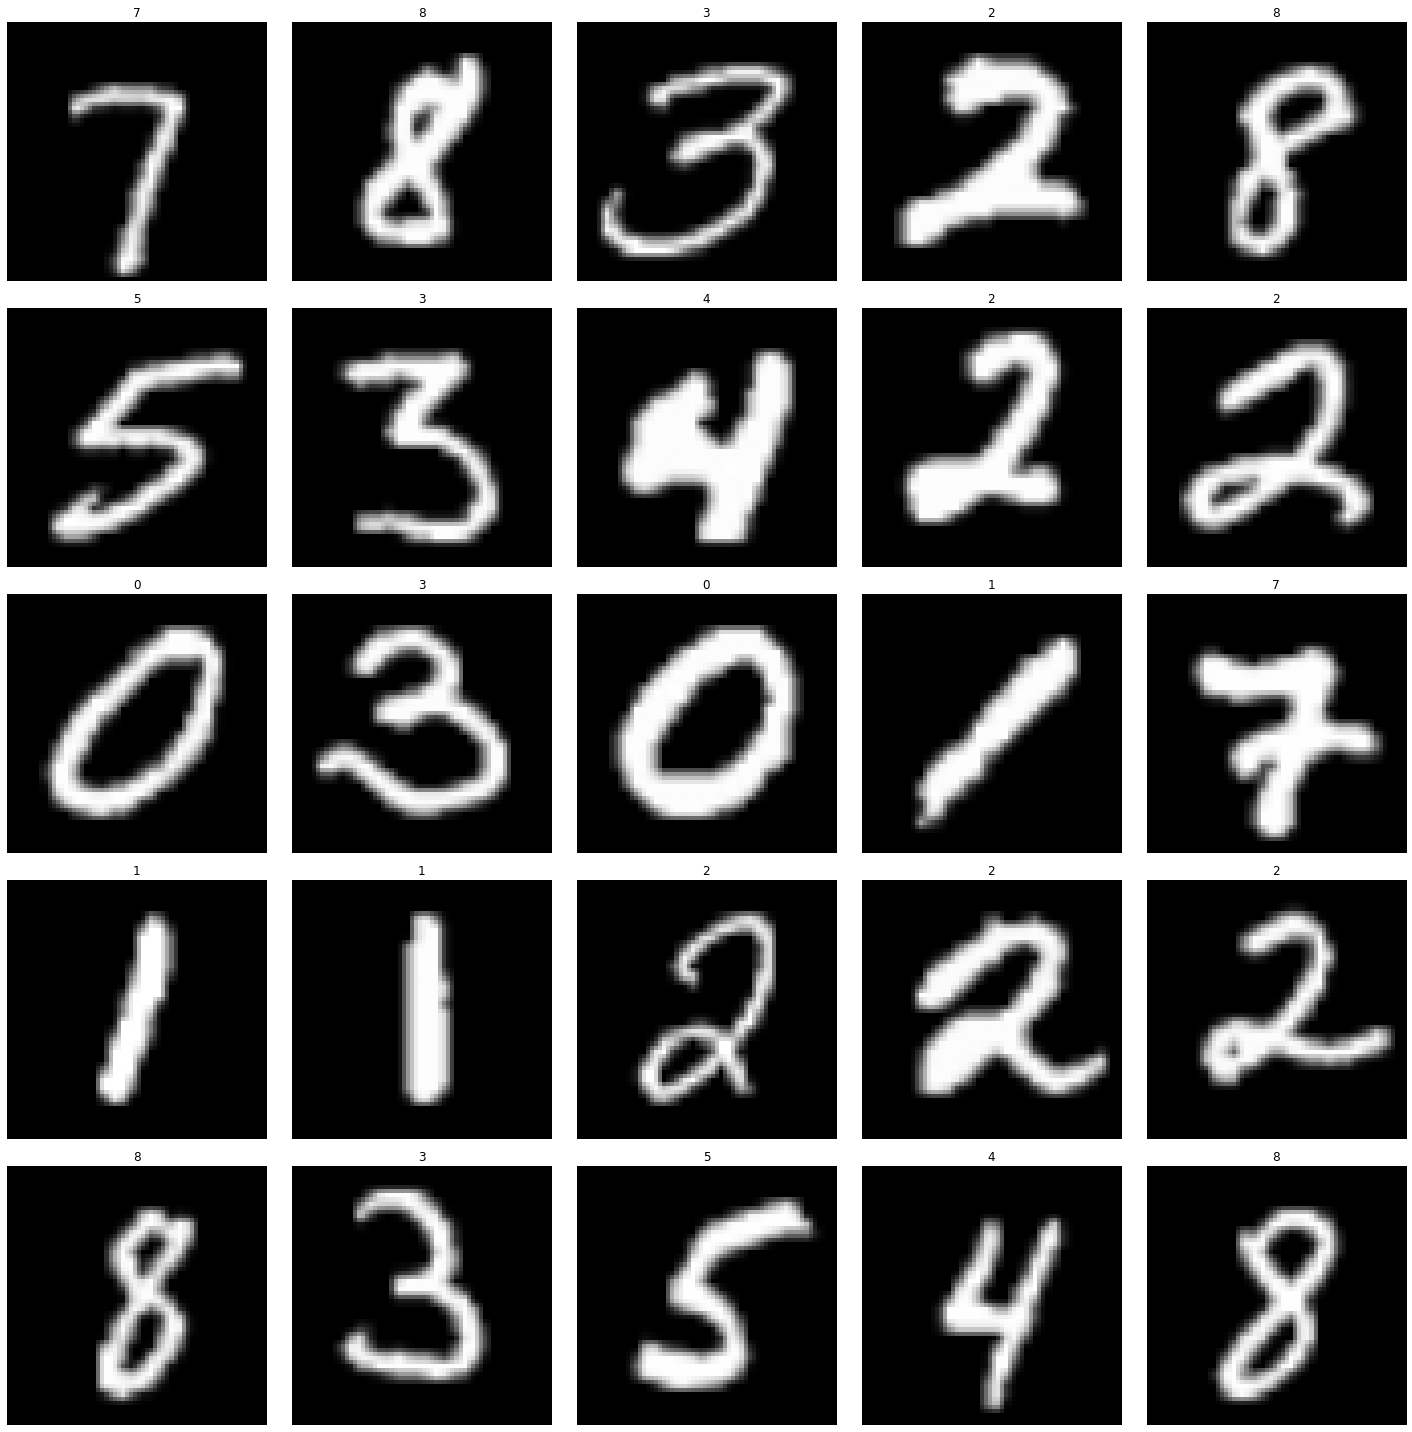

In [10]:
data = get_data(real_images_path, batch_size, img_size, n_classes)
data.show_batch()

In [11]:
data

ImageDataBunch;

Train: LabelList (70000 items)
x: BigGANItemList
,,,,
y: ImageCategoryList
,,,,
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (0 items)
x: BigGANItemList

y: ImageCategoryList

Path: /root/.fastai/data/mnist_png;

Test: None

# CRITIC

The simplest method to build a BigGAN discriminator is:

```
biggan_disc_64(in_n_channels: int=3, ch_mult: int=96, **disc_kwargs)`
```

It creates an architecture with the same depth and feature maps as in the paper.

The parameters `disc_kwargs` are passed through to `BigGANDiscriminator` constructor:

```
BigGANDiscriminator(in_sz: int, res_blocks_n_ftrs: List[Tuple[int, int]], 
                    idx_block_self_att: int, n_classes: int=1, 
                    down_op: genlab.core.layers.DownsamplingOperation2d=None, 
                    activ: nn.Module=None, init_func:Callable=_default_init,
                    flatten_out=False)
```

In [0]:
critic = biggan_disc_64(img_n_channels, ch_mult, n_classes=n_classes, flatten_out=True)

# GENERATOR

The simplest method to build a BigGAN generator is:

```
biggan_gen_64(out_n_channels: int=3, ch_mult: int=96, **gen_kwargs)
```

It creates an architecture with the same depth and feature maps as in the paper.

The parameters `gen_kwargs` are passed through to `BigGANGenerator` constructor:

```
BigGANGenerator(out_sz: int, out_n_channels: int, up_blocks_n_ftrs: List[Tuple[int, int]], 
                z_split_sz: int=20, n_classes: int=1, class_embedding_sz: int=128, 
                up_op: genlab.core.layers.UpsamplingOperation2d=None)
```

In [0]:
generator = biggan_gen_64(img_n_channels, ch_mult, n_classes=n_classes)

# LEARNER

In [0]:
g_loss, d_loss = hinge_adversarial_losses()
g_loss_reg = loss_func_with_kernel_regularizer(g_loss, 
                                               OrthogonalRegularizer(generator))

In [0]:
learner = ConditionalGANLearner(data, generator, critic, GANLossArgs(g_loss_reg, d_loss),
                                opt_func=partial(optim.Adam, betas=(0.,0.999)), wd=0.,
                                switch_eval=False)

# TRAINING

In [0]:
lr = 5e-4

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.942108,#na#,1.551032,0.782581,06:14
1,1.506547,#na#,0.808036,1.605973,06:15
2,1.507271,#na#,0.352135,1.739541,06:16


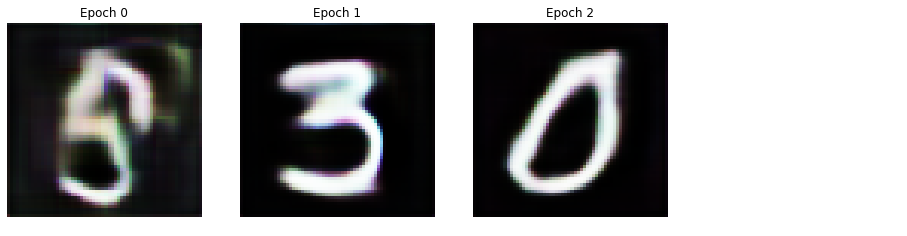

In [17]:
learner.fit(3, lr)
save_gan_learner(learner, models_root/'cbiggan-mnist-tr1-3ep.pth')

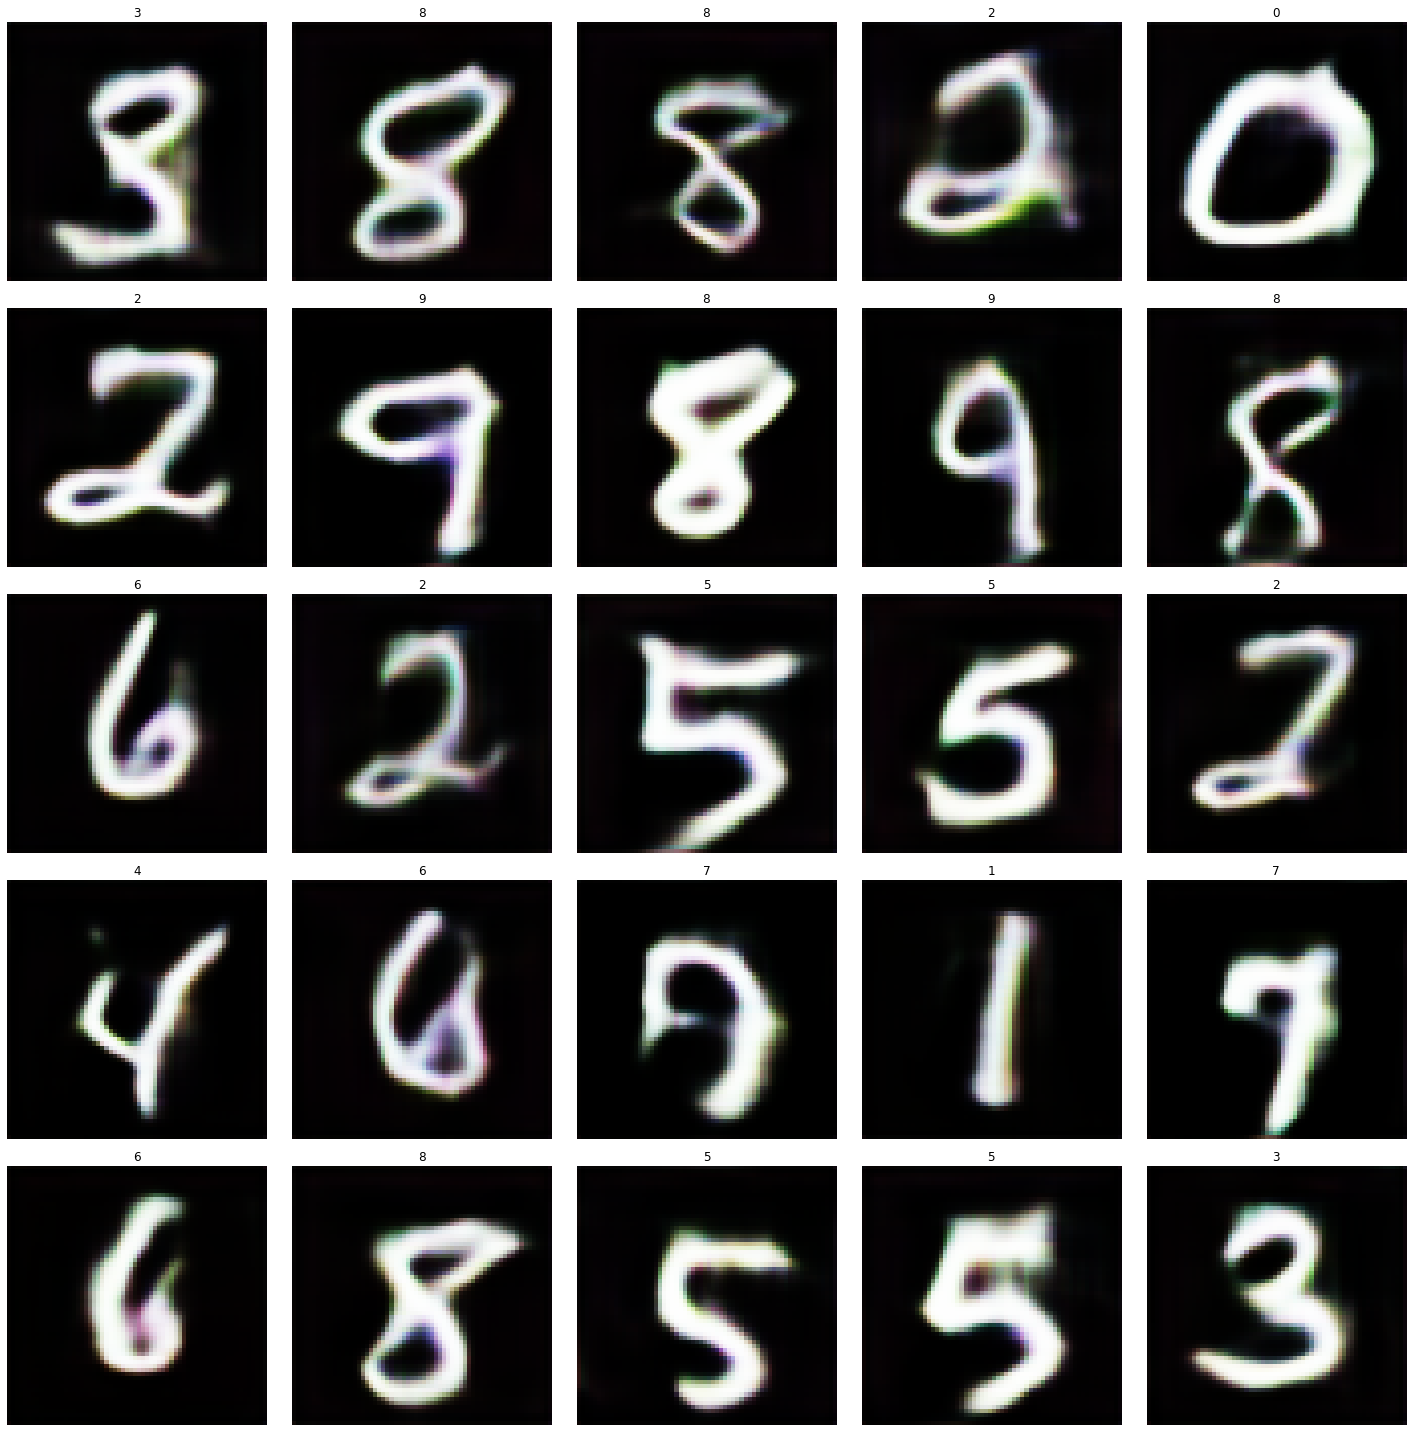

In [18]:
learner.show_results(ds_type=DatasetType.Train)